# Определение качества красного вина

За основу взят [датасет](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) и [ноутбук](https://www.kaggle.com/code/nimapourmoradi/red-wine-quality) 

## Импорты, конфигурация

In [2]:
!pip install gdown -q

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from phik.report import plot_correlation_matrix
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import joblib
import optuna


In [4]:
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)
sns.set_theme(palette='pastel')

In [5]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
os.environ['MKL_VERBOSE'] = '0'


In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Предварительный анализ доступных данных

In [7]:
# Скачивание данных
!gdown "https://docs.google.com/uc?export=download&id=1BeXuxcpLpGuLemkvyp5I7MOF-8bmaQuQ" -O "../data/winequality-red.csv"


Downloading...
From: https://docs.google.com/uc?export=download&id=1BeXuxcpLpGuLemkvyp5I7MOF-8bmaQuQ
To: /Users/igorinozemtsev/dev/learn/skillfactory/mlops-project/data/winequality-red.csv
100%|████████████████████████████████████████| 101k/101k [00:00<00:00, 13.7MB/s]


In [8]:
df = pd.read_csv('../data/winequality-red.csv')

In [9]:
df.sample(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
895,7.1,0.59,0.01,2.3,0.080,27.0,43.0,0.9955,3.42,0.58,10.7,6
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [11]:
df.isna().sum()


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [12]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Пропусков нет, целевой признак - `quality`.

## Исследовательский анализ

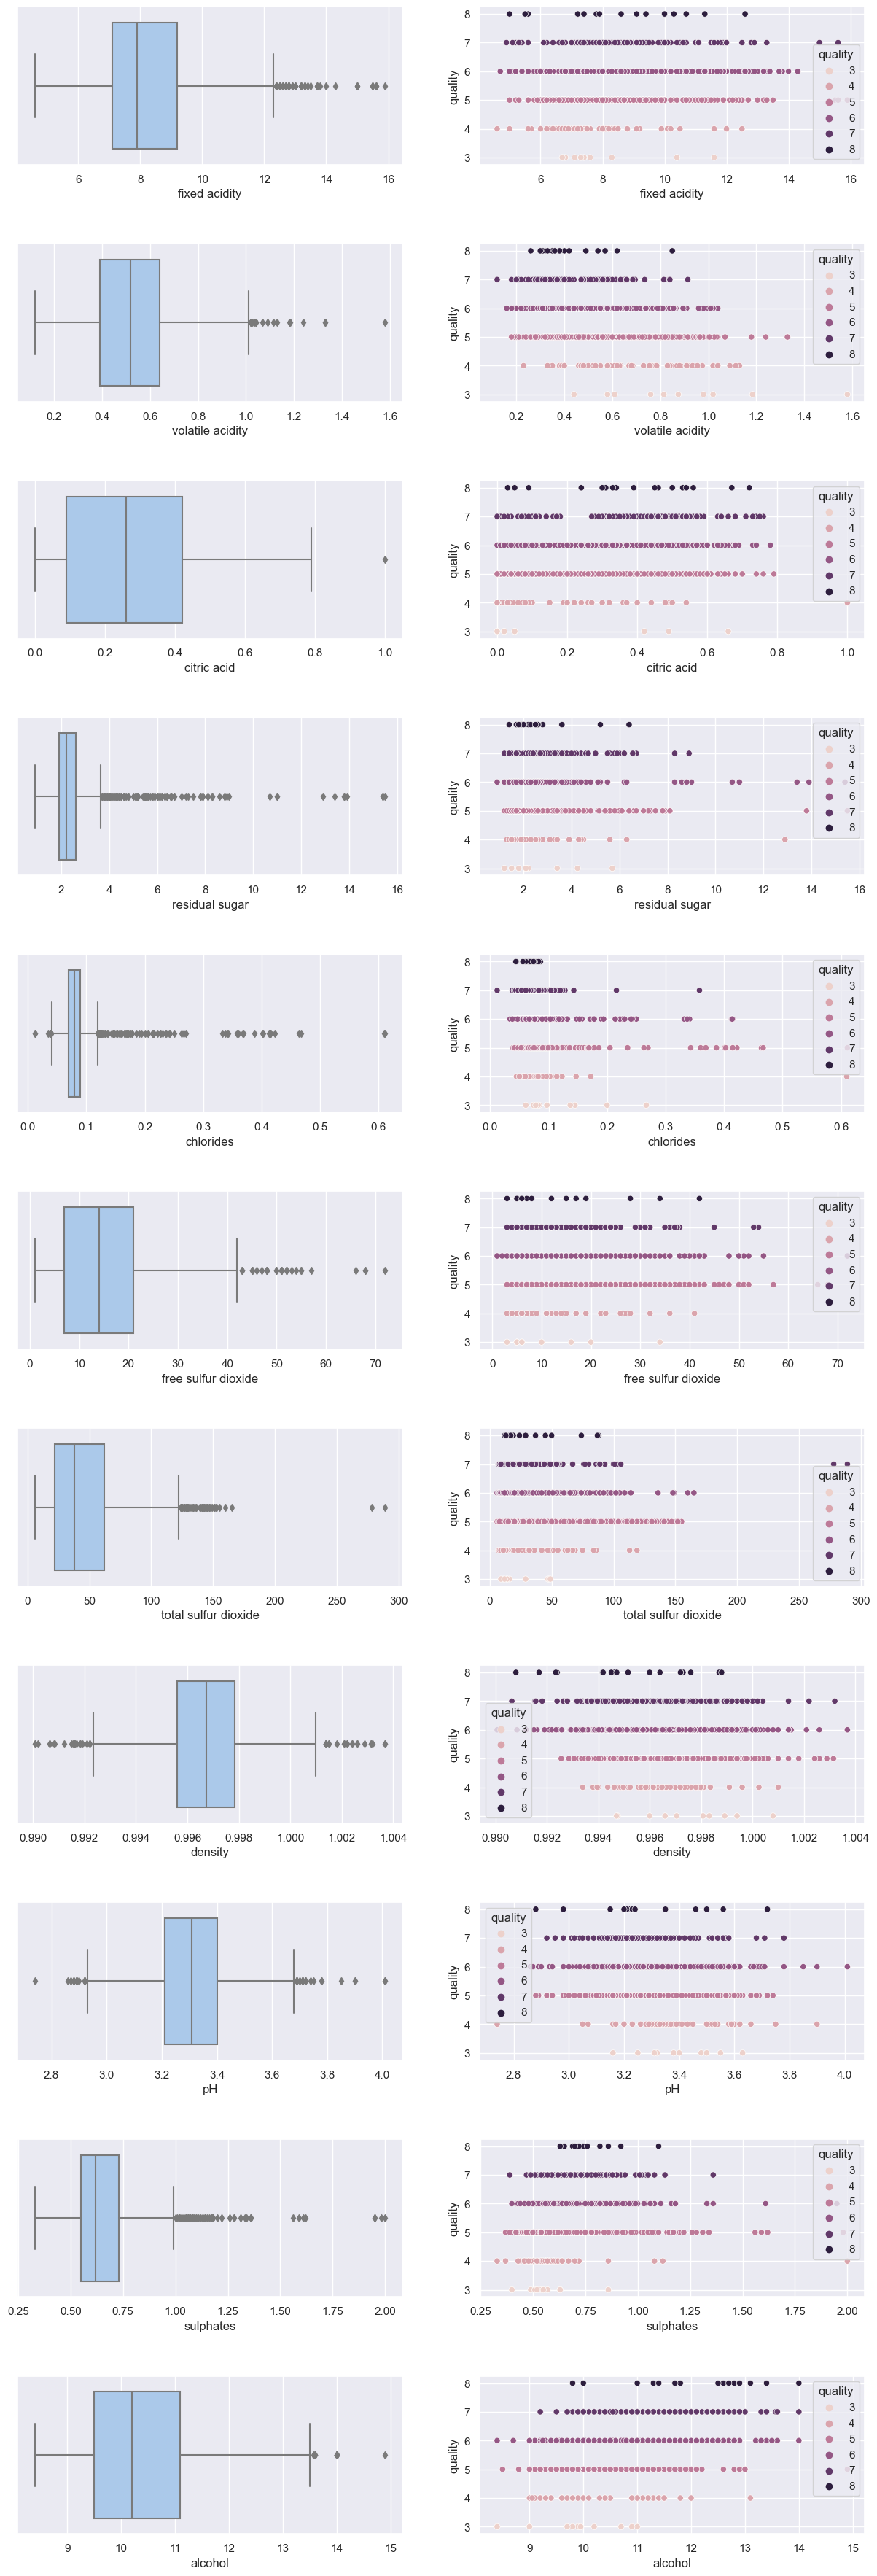

In [13]:
columns = list(df.columns)
fig, ax = plt.subplots(11, 2, figsize=(15, 45))
plt.subplots_adjust(hspace = 0.5)
for i in range(11) :
    sns.boxplot(x=columns[i], data=df, ax=ax[i, 0])
    sns.scatterplot(x=columns[i], y='quality', data=df, hue='quality', ax=ax[i, 1])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


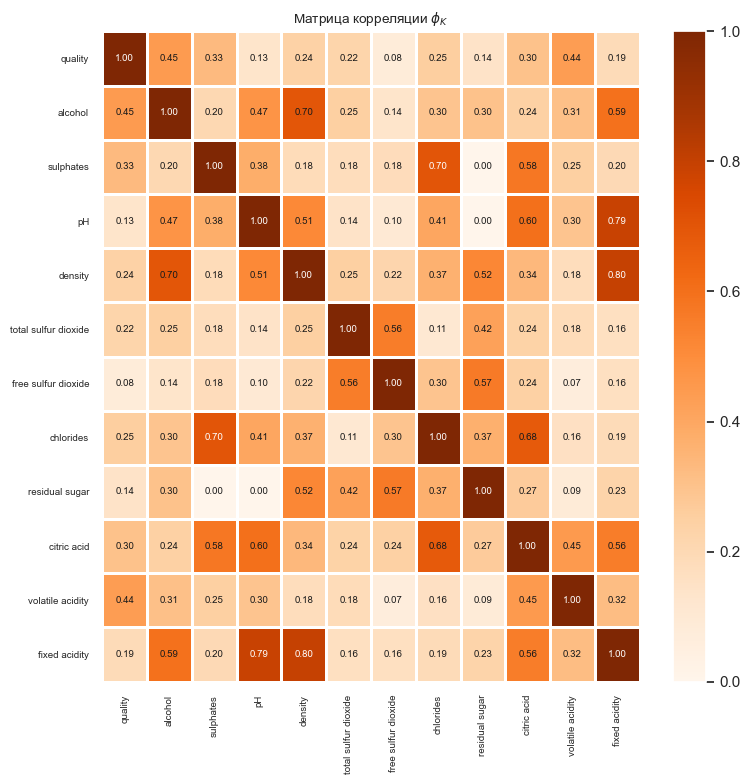

In [14]:
phik_overview = df.phik_matrix(interval_cols=list(df.columns))
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, 
    vmax=1, 
    color_map='Oranges',
    title=r'Матрица корреляции $\phi_K$',
    fontsize_factor=0.7,
    figsize=(8, 8),
)

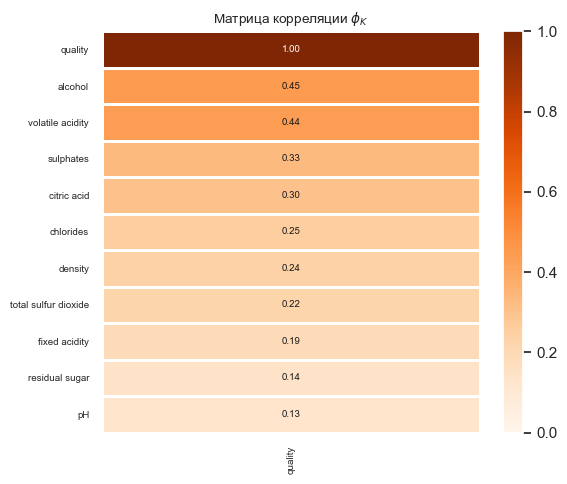

In [15]:
phik_overview_corr = phik_overview.loc[:, ['quality']].sort_values('quality', ascending=True)[1:]
plot_correlation_matrix(
    phik_overview_corr.values,
    x_labels=phik_overview_corr.columns,
    y_labels=phik_overview_corr.index,
    vmin=0, 
    vmax=1, 
    color_map='Oranges',
    title=r'Матрица корреляции $\phi_K$',
    fontsize_factor=0.7,
    figsize=(6, 5)
)



Наблюдаю заметную корреляцию целевого признака с:
- alcohol
- sulphates
- volatile acidity

## Подготовка данных для обучения

In [16]:
def drop_duplicated(df):
    """
    Принимает на вход датафрейм и удаляет у него явные дубликаты
    """
    if len(df.duplicated().unique()) > 1:
        return df.drop_duplicates().reset_index(drop=True)
    return df

In [17]:
result = drop_duplicated(df)
result.shape

(1359, 12)

In [18]:
X = result.drop('quality', axis=1)
y = result['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


In [19]:
num_columns = list(X.columns)

In [20]:
num_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('minMax', MinMaxScaler()),
])

In [21]:
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_columns),
], remainder='passthrough')

In [23]:
def objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-6, 1e2, log=True),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga'])
    }

    result_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE, **param))
    ])

    score = cross_val_score(result_pipe, X_train, y_train, cv=5, scoring='accuracy').mean()
    
    return score


In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Лучшая попытка:")
trial = study.best_trial

print(f"  Значение метрики: {trial.value}")
print("  Параметры: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-06-13 10:59:50,713] A new study created in memory with name: no-name-7c881e49-3e55-468f-84c7-582880148e97
[I 2024-06-13 10:59:50,914] Trial 0 finished with value: 0.4210035738433304 and parameters: {'C': 5.631394086233863e-06, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.4210035738433304.
[I 2024-06-13 10:59:51,066] Trial 1 finished with value: 0.5741282719984546 and parameters: {'C': 61.257273497033395, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5741282719984546.
[I 2024-06-13 10:59:51,137] Trial 2 finished with value: 0.46518400463633724 and parameters: {'C': 0.0043987252503429036, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5741282719984546.
[I 2024-06-13 10:59:51,244] Trial 3 finished with value: 0.5564522360668406 and parameters: {'C': 0.40808853279143803, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5741282719984546.
[I 2024-06-13 10:59:51,311] Trial 4 finished with value: 0.5554670143919637 and parameters: {'C': 0.11882756556276951, 'solver': 'saga

[I 2024-06-13 10:59:56,909] Trial 44 finished with value: 0.5760987153482082 and parameters: {'C': 27.870938133815297, 'solver': 'saga'}. Best is trial 10 with value: 0.577079107505071.
[I 2024-06-13 10:59:57,069] Trial 45 finished with value: 0.5770694484690428 and parameters: {'C': 56.20788606221032, 'solver': 'lbfgs'}. Best is trial 10 with value: 0.577079107505071.
[I 2024-06-13 10:59:57,197] Trial 46 finished with value: 0.570177726262919 and parameters: {'C': 2.1744890364110696, 'solver': 'saga'}. Best is trial 10 with value: 0.577079107505071.
[I 2024-06-13 10:59:57,348] Trial 47 finished with value: 0.4210035738433304 and parameters: {'C': 1.7314523048144016e-05, 'solver': 'saga'}. Best is trial 10 with value: 0.577079107505071.
[I 2024-06-13 10:59:57,413] Trial 48 finished with value: 0.5328841881580219 and parameters: {'C': 0.037369085637930476, 'solver': 'saga'}. Best is trial 10 with value: 0.577079107505071.
[I 2024-06-13 10:59:57,482] Trial 49 finished with value: 0.55547

Лучшая попытка:
  Значение метрики: 0.577079107505071
  Параметры: 
    C: 33.21828820270647
    solver: saga


In [31]:
best_params = trial.params
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE, **best_params))
])

best_model.fit(X_train, y_train)

joblib.dump(best_model, '../models/model.pkl');
